In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [20]:
#The Wikipedia page was changed on November, 2019
#We will use the older version
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canad%D7%A9a:_M&oldid=926306543"
res = requests.get(url)

In [21]:
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))
df = data[data['Borough'] != 'Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [22]:
#Grouping by Borough and Postcode
df = df.groupby(['Postcode','Borough'], as_index=False).agg(','.join)
df = df.sample(frac=1).reset_index(drop=True)
df

,Postcode,Borough,Neighbourhood
0,M5N,Central Toronto,Roselawn
1,M4C,East York,Woodbine Heights
2,M7R,Mississauga,Canada Post Gateway Processing Centre
3,M4X,Downtown Toronto,"Cabbagetown,St. James Town"
4,M2M,North York,"Newtonbrook,Willowdale"
5,M1G,Scarborough,Woburn
6,M4R,Central Toronto,North Toronto West
7,M1N,Scarborough,"Birch Cliff,Cliffside West"
8,M6L,North York,"Downsview,North Park,Upwood Park"
9,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station"


In [23]:
df.shape

(103, 3)

In [24]:
###Second part of the assignment

In [25]:
geospatial_url = "https://cocl.us/Geospatial_data"
latlondata = pd.read_csv(geospatial_url)

In [26]:
latlondata.columns=['Postcode','Latitude','Longitude']
latlondata.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [27]:
#Merging of the neighbourhood database and the geospatial data
data = pd.merge(df, latlondata, on='Postcode')

In [28]:
data['Location'] = list(zip(data['Latitude'], data['Longitude']))

In [29]:
data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Location
0,M5N,Central Toronto,Roselawn,43.711695,-79.416936,"(43.7116948, -79.41693559999999)"
1,M4C,East York,Woodbine Heights,43.695344,-79.318389,"(43.695343900000005, -79.3183887)"
2,M7R,Mississauga,Canada Post Gateway Processing Centre,43.636966,-79.615819,"(43.6369656, -79.61581899999999)"
3,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,"(43.667967, -79.3676753)"
4,M2M,North York,"Newtonbrook,Willowdale",43.789053,-79.408493,"(43.789053, -79.40849279999999)"


In [30]:
#How to find a geographical location in geolocator

In [40]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [45]:
# 3d part of the assignment

In [46]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

In [48]:
# add markers to map
for lat, lng, label in zip(data['Latitude'], data['Longitude'], data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

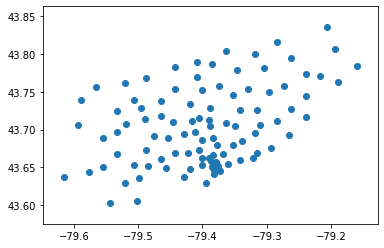

In [154]:
#Kmeans
datal=data[['Longitude','Latitude']]
import matplotlib.pyplot as plt
plt.scatter(datal['Longitude'], datal['Latitude'])

In [155]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12)

In [156]:
k_means.fit(datal)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [157]:
labels = pd.DataFrame.from_dict(k_means.labels_, dtype='float')
labels.columns=['Labels']
labels

,Labels
0,0.0
1,3.0
2,2.0
3,3.0
4,0.0
5,1.0
6,0.0
7,1.0
8,2.0
9,3.0


In [162]:
datal=datal.join(labels)
datal

,Longitude,Latitude,Labels
0,-79.416936,43.711695,0.0
1,-79.318389,43.695344,3.0
2,-79.615819,43.636966,2.0
3,-79.367675,43.667967,3.0
4,-79.408493,43.789053,0.0
5,-79.216917,43.770992,1.0
6,-79.405678,43.715383,0.0
7,-79.264848,43.692657,1.0
8,-79.490074,43.713756,2.0
9,-79.381752,43.640816,3.0


In [163]:
locations = datal[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

In [169]:
locationlist

[[43.7116948, -79.41693559999999],
 [43.695343900000005, -79.3183887],
 [43.6369656, -79.61581899999999],
 [43.667967, -79.3676753],
 [43.789053, -79.40849279999999],
 [43.7709921, -79.21691740000001],
 [43.7153834, -79.40567840000001],
 [43.692657000000004, -79.2648481],
 [43.713756200000006, -79.4900738],
 [43.6408157, -79.38175229999999],
 [43.6056466, -79.50132070000001],
 [43.7063972, -79.309937],
 [43.836124700000006, -79.20563609999999],
 [43.745905799999996, -79.352188],
 [43.6571618, -79.37893709999999],
 [43.7043244, -79.3887901],
 [43.7332825, -79.4197497],
 [43.706748299999994, -79.5940544],
 [43.718517999999996, -79.46476329999999],
 [43.7635726, -79.1887115],
 [43.6658599, -79.38315990000001],
 [43.7845351, -79.16049709999999],
 [43.6678556, -79.53224240000002],
 [43.67635739999999, -79.2930312],
 [43.7563033, -79.56596329999999],
 [43.7816375, -79.3043021],
 [43.799525200000005, -79.3183887],
 [43.7574096, -79.27330400000001],
 [43.7942003, -79.26202940000002],
 [43.6471

In [178]:
def regioncolors(counter):
    if counter['Labels'] == 1:
        return 'green'
    elif counter['Labels'] == 0:
        return 'blue'
    elif counter['Labels'] == 2:
        return 'red'
    else:
        return 'darkblue'

In [179]:
datal["color"] = datal.apply(regioncolors, axis=1)
datal

,Longitude,Latitude,Labels,color
0,-79.416936,43.711695,0.0,blue
1,-79.318389,43.695344,3.0,darkblue
2,-79.615819,43.636966,2.0,red
3,-79.367675,43.667967,3.0,darkblue
4,-79.408493,43.789053,0.0,blue
5,-79.216917,43.770992,1.0,green
6,-79.405678,43.715383,0.0,blue
7,-79.264848,43.692657,1.0,green
8,-79.490074,43.713756,2.0,red
9,-79.381752,43.640816,3.0,darkblue


In [180]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)


for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point],
                  icon=folium.Icon(color=datal["color"][point],
                                   icon_color='white',
                                   icon='circle',
                                   angle=0, prefix='fa')).add_to(map_toronto)

display(map_toronto)